# Programming Assignment 6: Neural Networks

In the previous assignments, we learned about **text preprocessing tools** like tokenization and regular expressions, **NLP tasks** like information retrieval and sentiment
analysis, and **task-solving tools** like word vectors, Naive Bayes, and logistic regression.

This time, we’ll integrate and expand these ideas to build a new and
powerful tool for your NLP toolkit: a simple neural network!

Neural networks are extremely useful and powerful tools that are behind some
really impressive advances in NLP over the last few years. You'll see plenty of
them in future NLP classes (if you choose to take them), but hopefully this
assignment will give you a first taste of how they work and what you can do
with them!

## Part 0. Environment Check

Before we do anything else, let's quickly check that you're running the correct
version of Python and are in the right environment!

In [1]:
import os
from typing import Dict, List, Tuple

import gensim.models



If the above cell complains, it means that you're using the wrong environment
or Python version!

If so, please exit this notebook, kill the notebook server with CTRL-C, and
try running

$ conda activate cs124

then restarting your notebook server with

$ jupyter notebook

If that doesn't work, you should go back and follow the installation
instructions in PA0.

## Part 1.1: Why not Logistic Regression?

Before we build a simple neural network, let's take a brief look back at
logistic regression (from PA2). Recall that the output of a logistic regression classifier is given by:

$y = \sigma(XW + b)$ 

$X$ is a matrix of shape (num_examples, num_features), so that each row is a training example.

$W$ is a vector of shape (num_features, 1), so that it transfers each example in X from a num_features-dimensional vector to a 1-dimensional scalar output. In other words, the computation result $XW$ is of shape (num_examples, 1).

Finally, $b$ is a scalar added to every element of the vector $XW$, and $\sigma()$ is the
sigmoid function.


This approach worked really well on the text classification task in PA2. Yet in this section, we will reveal its weakness. 

To see that, let's bring out a toy dataset.

In [2]:
# imports
import numpy as np

np.random.seed(1)

from util import *

In [3]:
%matplotlib inline

In [4]:
# Construct a toy dataset
X, y = generate_2d_xor_dataset()

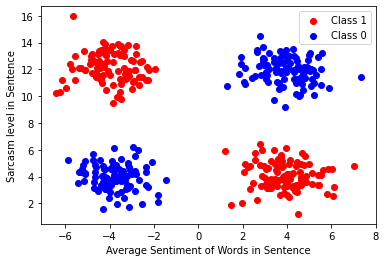

In [5]:
# Plot our example dataset
plot_2d_dataset_points(X, y)

This distribution may look a bit unusual at first sight, but datasets with this sort of property actually appear quite often in real life. 

As an example, consider the case of doing sentiment analysis, but in the presence of sarcasm. Let each data point represent a sentence, with the $x$ value representing
the average sentiment score of the words in the sentence, and the $y$ value
representing the amount of sarcasm detected in the sentence (assume this is measurable). Again, a datapoint is labeled as 0 (blue) if its true
sentiment is negative, and it's labeled as 1 (red) if its true sentiment is positive.

Under this setting, a sentence with high sentiment score and high sarcasm score, such as "Woooooow, what a FANTASTIC day, I hope it NEVER ends." will appear on the top right of the figure and be labeled as negative. Meanwhile, a genuinely good review – "The food is good and the service is kind" – will have a high sentiment score and low sarcasm score. So, this second review will appear on the bottom right of the figure and be labeled as positive.

NOTE: In case you're curious, this dataset was actually generated from 4 normal
distributions with different means and unit variances.

Here, let's learn this task with Scikit-learn's pre-written Logsitic Regression.

In [5]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression classifier on our data
logistic_regression_classifier = LogisticRegression().fit(X, np.squeeze(y))

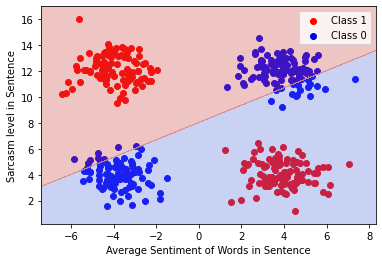

In [6]:
plot_points_with_classifier_predictions(X, y, logistic_regression_classifier)

In this plot, the region shaded in blue is where the classifier predicts as 0 (negative sentiment). The region shaded in red is where it predicts as 1. As one can observe, the prediction is way off!

Why is this the case? Write your answer below.

In [10]:
def logistic_regression_failure_response():
    """
    TODO: Write your response below.
    """
    return "the red point is in blue shade"

## Part 1.2 One Solution: A Simple Neural Network

A neural network is made up of a series of layers. Each layer looks
almost exactly like a logistic regression classifier, written as:

$a_l = f(a_{l-1}W_l + b_l)$

Where $a_l$ represents the output of layer $l$, $a_{l-1}$ represents the output from the previous layer (or input X if l-1=0), and $f()$ is a non-linear
function called the __activation function__. The sigmoid() used in logistic regression is a kind of activation function. In fact, you can think of logistic regression as a single-layer neural network!

### Implementation roadmap
<a id='roadmap'></a>

The following notebook code cell defines a multi-layer neural network class `StackedLogisticRegressionNetwork` you are going to implement. It is a big chunk of code and can be intimidating, since it contains all of its necessary features and methods in one piece -- an unfortunate fact of python class definitions. But do not fear! We've broken it down into steps, and have written intermediate unit tests and sanity checks to guide you along the way.

Follow the following steps and you can implement a neural network of your own! 

For your convenience, we've provided links to jump across to cells in this notebook, but in some contexts, such as Google Colab, these links do not work. In that case, please follow the "**STEP x**' labels in the notebook.

- **[STEP 1](#step1): Implement the `__init__()` method.** This defines and initializes the weight matrices/vectors of the neural network. You can find more in the description below.
- **[STEP 2](#step2): Run a sanity check for the `__init__()` method**.
- **[STEP 3](#step3): Implement the `forward_pass()` method**. This is the main body of the neural network's computation. 
- **[STEP 4](#step4): Debug/run a sanity check for the the `forward_pass()` method**. This code cell provides some sample code to debug `forward_pass()`, if you're stuck.
- **[STEP 5](#step5): Implement the `backward_pass()` method**. You will implement backward propogation to compute gradients for weights in the neural network.
- **[STEP 6](#step6): Debug/run a sanity check for the the `backward_pass()` method**. This code cell provides some sample code to debug `forward_pass()`, if you're stuck.
- **[STEP 7](#step7): Implement and test the `predict()` method**. This basically converts the model's final output into a binary prediction.
- **[STEP 8](#step8): Training and evaluating your neural network**. Run the training and evaluation code that we provide to train and evaluate your neural network!

**Important coding tip 1:** When writing code for neural networks, it is useful to frequently check the shape of any intermediate vectors or tensors as you are writing them, instead of implementing the whole forward/backward method without testing in one setting and try to debug later. To do this, use a toy input to call the `forward_pass()` or `backward_pass()` function, even though it might not be completely implemented, and print out as much information as you can! We've provided some code in STEP 4 and STEP 6 for you to do this.

**Important coding tip 2:** At all costs, avoid using for loops when you are implementing computations involving vectors or matrices. Instead, use the various matrix/vector operations that numpy provides.

__WARNING:__ The sanity checks provided above do __NOT__ provide
a guarantee that your implementation is 100% correct. We encourage you to
do additional checking and testing to convince yourself that everything
is working correctly. You can see how the checks are implemented in util.py.

### (STEP 1)  The network architecture and initializing weights. <a id='step1'></a>

The first step is to complete the `__init__()` method to defines and initializes the weight matrices/vectors of the neural network.

Recall the previous definition of a neural network layer:

$a_l = f(a_{l-1}W_l + b_l)$

Where $a_l$ represents the output of layer $l$, $a_{l-1}$ represents the output from the previous layer (or input X if l-1=0), and we use the sigmoid function for $f()$.

Note that we are computing with examples in batch. That means, we are running multiple examples through the network at the same time. Each example occupies one row in $a_l$. 

Suppose $a_{l-1}$ has shape (N, D1) where N is the number of examples in $a_l$ and D1 is the size of each example's current feature vector. Suppose $W$ has shape (D1, D2). Then $a_l$ will be of shape (N, D2). Essentially, the matrix multiplication between $a_{l-1}$ and $W$ maps each example's features of size D1 (as a row vector in $a_{l-1}$) into a new set of features of size D2 (as a row vector in $a_{l}$). The transformation is non-linear because $f()$ is a non-linear function, and all examples are transformed in parallel without interfering with each other. (Think about why this is the case!)

We want to implement a feed-forward neural network with 3 layers, including 2 hidden layers and 1 output layer. We denote the output of each layer as $a_1$, $a_2$, and $a_3$. Each layer has two trainable parameters, $W$ and $b$, as we have explained before.

After you implement `__init__()`, be sure to proceed to [STEP 2](#step2) to check your implementation is correct!

<a id='nn_code'></a>

In [24]:
class StackedLogisticRegressionNetwork:
    def __init__(self, input_size: int, layer_1_size: int, layer_2_size: int,
                 seed: int = 1234):
        """
        STEP 1 TODO: Initialize the weights and biases of the 3 layers. You should
        initialize the weights randomly with initialize_weights() for each
        layer, and initialize the biases to zero for each layer.

        Args:
            input_size (int): The size of the input (number of input features/
                             number of dimensions of the input points).
            layer_1_size (int): The number of hidden units in the first hidden
                                layer.
            layer_2_size (int): The number of hidden units in the second hidden
                                layer.
            seed (int): Random seed to use when initializing weights.
        """
        np.random.seed(seed)

        ######################## STEP 1: YOUR CODE STARTS HERE #########################
        # HINT1: You should use self.initialize_weights() to initialize Ws 
        #      (read this function's header below for details),
        #      and use np.zeros() to initialize bs. 
        #      (https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)
              
        # HINT2: The shape of the bias for each layer should be (1, layer_size).

        # WARNING: Do NOT change the order in which the weights are initialized.
               
        self.W_1 = self.initialize_weights(input_size, layer_1_size)
        self.b_1 = np.zeros((1, layer_1_size))
        self.W_2 = self.initialize_weights(layer_1_size, layer_2_size)
        self.b_2 = np.zeros((1, layer_2_size))
        self.W_3 = self.initialize_weights(layer_2_size, 1) # ket qua chi la 0 hoac 1 , nhi phan
        # nen so chieu la 1 
        self.b_3 = np.zeros((1, 1))
        ######################## STEP 1: YOUR CODE ENDS HERE ###########################
        # Now proceed to STEP 2 to check your implementation
        ################################################################################
        
        self.variables = {
          "W_1": self.W_1,
          "b_1": self.b_1,
          "W_2": self.W_2,
          "b_2": self.b_2,
          "W_3": self.W_3,
          "b_3": self.b_3
        }

    @staticmethod
    def initialize_weights(num_inputs: int, num_outputs: int) -> np.ndarray:
        """
        Initialize the weights in a specific way to help gradient descent
        converge better (Glorot initialization).

        Args:
            num_inputs (int): The number of inputs to the layer.
            num_outputs (int): The number of outputs (units) in the layer.

        Returns:
            np.ndarray: A fully initialized NumPy array of weights, of shape
            (num_inputs, num_outputs)
        """
        bound = np.sqrt(6 /(num_inputs + num_outputs))
        return np.random.uniform(-bound, bound, (num_inputs, num_outputs))

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """
        The sigmoid function, exactly the same as in PA2. NOTE: Applied
        element-wise to each element in the array x.

        Args:
            x (np.ndarray): A NumPy array.

        Returns:
            np.ndarray: An array of the sigmoid function applied to each element
                        of x. Shape is the same as x.
        """
        return 1 / (1 + np.exp(-x))

    def forward_pass(self, X: np.ndarray) ->\
            Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        STEP 3 TODO: Calculate the outputs of each of the three layers in the model
        using the inputs, weights, and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of three NumPy
                arrays, corresponding to the output (after activation) of the
                first layer ($a_1$), second layer ($a_2$), and third/output
                layer ($a_3$).
        """

        ######################## STEP 3: YOUR CODE STARTS HERE #########################
        # HINT1: Your output a_1 should look exactly like the output of a logistic
        # regression classifier on X. Your output a_2 should look exactly like
        # the output of another logistic regression classifier on the input a_1.
        # And same again for a_3. Note that you should use the appropriate
        # weights and biases for each part though.

        # HINT2: Don't forget to apply self.sigmoid() between each layer!
        
        a_1 = self.sigmoid(X @ self.W_1 + self.b_1)
        a_2 = self.sigmoid(a_1 @ self.W_2 + self.b_2)
        a_3 = self.sigmoid(a_2 @ self.W_3 + self.b_3)
        
        ######################## STEP 3: YOUR CODE ENDS HERE ###########################
        # Now proceed to STEP 4 to check your implementation
        ################################################################################
        
        return a_1, a_2, a_3

    def backward_pass(self,
                      X : np.ndarray,
                      y : np.ndarray,
                      a_1: np.ndarray,
                      a_2: np.ndarray,
                      a_3: np.ndarray
                      ) -> Dict[str, np.ndarray]:
        """
        STEP 5 TODO: Use the examples, labels, and model outputs to compute the
        gradient for each of the weights and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1).
            a_1 (np.ndarray): The output of the first logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_2 (np.ndarray): The output of the second logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_3 (np.ndarray): The output of the third logistic regression
                              layer (after activation). Computed in
                              forward_pass().

        Returns:
            Dict[str, np.ndarray]: A dictionary of the gradients computed for
                                    each weight and bias parameter. The keys
                                    are strings, the values are NumPy arrays
                                    (see the names of the keys below).
        """

        ######################## STEP 5: YOUR CODE STARTS HERE #########################
        # NOTE: We use dW_3 to denote the loss J's derivative with respect to W_3,
        #      db_3 to denote its derivative with respect to b_3, and so on.

        # HINT: You'll probably find it useful to compute:
        #  - dz_3
        #  - da_2
        #  - dz_2
        #  - da_1
        #  - dz_1
        #  as you do your calculations.
        dW_3 = None
        db_3 = None
        dW_2 = None
        db_2 = None
        dW_1 = None
        db_1 = None
        ######################## STEP 5: YOUR CODE ENDS HERE ###########################
        # Now proceed to STEP 6 to check your implementation.
        ################################################################################

        # Return the gradients
        gradients = {
          "W_3": dW_3,
          "b_3": db_3,
          "W_2": dW_2,
          "b_2": db_2,
          "W_1": dW_1,
          "b_1": db_1
        }
        return gradients

    @staticmethod
    def loss(y_hat : np.ndarray,
             y : np.ndarray,
             epsilon: float=1e-16) -> float:
        """
        Computes the average binary cross-entropy loss over all examples. This
        is the same loss function we implemented for logistic regression in PA2.

        Args:
            y_hat (np.ndarray): The NumPy array of our prediction scores. This
                                is the same as the output a_3 from
                                forward_pass(). It is of shape
                                (num_examples, 1), and
                                each element is between 0.0 and 1.0.
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            epsilon (float): A tiny value used to clip y_hat so that it is never
                             accidentally rounded to 1.0 or 0.0, causing
                             the log to become undefined.

        Returns:
            float: The average binary cross-entropy loss over the num_examples
                    examples.
        """
        # We clip the predictions so they can never become exactly 0 or 1.
        # This would cause the log of the predictions to be undefined.
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        return -1 * np.mean(y * np.log(y_hat) + (1.0 - y) * np.log(1.0 - y_hat))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        STEP 7 TODO: Convert the prediction scores (output a_3 in self.forward_pass())
        to binary predictions.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            np.ndarray: A NumPy array of shape (num_examples, 1) containing the
                        predicted class for each example. Each element should
                        be either 0 or 1.
        """
        ######################## STEP 7: YOUR CODE STARTS HERE #########################
        # HINT: The predictions scores will be numbers between 0 and 1. 
        # For example, a prediction score of 0.8 means that the neural network thinks
        # there is an 80% chance it is in class 1 and a 20% chance that it is in
        # class 0. 
    
        # Your job is to take this score and round it to an INTEGER 0 or 1.
        # You should convert all scores >= 0.5 to 1 and others to 0.

        predictions = None
        ######################## STEP 7: YOUR CODE ENDS HERE ###########################
        # Be sure to run the sanity check after STEP 7 !
        ################################################################################
        return predictions

    def train(self,
              X_train: np.ndarray,
              y_train: np.ndarray,
              learning_rate: float = 0.01,
              num_epochs: int = 1000,
              print_every: int = 5,
              verbose: bool=True):
        """
        Trains the neural network using gradient descent.

        Args:
            X_train (np.ndarray): The NumPy array of training examples, of shape
                            (num_examples, input_size).
            y_train (np.ndarray): The NumPy array of true labels for each
                            example in X_train. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            learning_rate (np.ndarray): Step size parameter for gradient
                                descent.
            num_epochs (int): The number of epochs (full passes through the
                                provided training data) to train the model for.
            print_every (int): Number of epochs to wait between printouts of the
                                training loss and accuracy during training.
            verbose (bool): Whether to print any training output.

        This code should look very familiar to you from PA2. It's pretty much
        exactly the same code we used to train our logistic regression model,
        except this time you implemented the part that computes the gradients!
        """
        for epoch in range(1, num_epochs + 1):
            a_1, a_2, a_3 = self.forward_pass(X_train)
            gradients = self.backward_pass(X_train, y_train, a_1, a_2, a_3)
            # Update the weights with gradient descent
            for name, grad in gradients.items():
                self.variables[name] -= learning_rate * grad
            # Occasionally print out the training loss and accuracy
            if verbose and epoch % print_every == 0:
                loss = self.loss(a_3, y_train)
                accuracy = np.mean(self.predict(X_train) == y_train)
                print("Epoch: {} | Training Loss: {} | Training Accuracy: {}".format(
                    epoch, loss, accuracy))
        print("Finished training!")

### (STEP 2) Sanity check for `__init__()` <a id='step2'></a> 

Run the following cell (`check_parameter_shapes`) to check if you've implemented `__init__()` correctly.

Specifically, it checks the shapes of all trainable parameters Ws and bs.

If all things are correct, proceed to **[STEP 3](#step3)** below!

(Click [here](#roadmap) to return to the implementation roadmap that contains an outline of all the steps.)

In [23]:
# STEP 2
check_parameter_shapes(StackedLogisticRegressionNetwork)

All parameter shapes are correct.


### (STEP 3) The forward pass <a id='step3'></a>

The next step is to implement the method `forward_pass()`, i.e. the main body of the neural network's computation.

The network runs the input $X$ ($\in R^{\text{num_examples} \times \text{input_size}}$) through its layers to get a probability vector $y$ ($\in R^{\text{num_examples}\times 1}$). The i-th value in $y$ should indicate the probability of the i-th example in $X$ to express a positive sentiment.

We have done all the math for you, so you only need to implement these equations in numpy. Think about the shape of each intermediate variable, and use print(x.shape) to debug if you encounter "shape mismatch" errors.

$z_1 = X W_1 + b_1$

$a_1 = \sigma(z_1)$

$z_2 = a_1 W_2 + b_2$

$a_2 = \sigma(z_2)$

$z_3 = a_2 W_3 + b_3$

$y = a_3 = \sigma(z_3)$

**Important coding tip**: All the multiplications here are matrix multiplication. There are three ways to perform matrix multiplication in numpy. Suppose you want to multiply $A \in R^{mxn}$ and $B \in R^{nxk}$, the following expressions are equivalent:

`A @ B`

`A.dot(B)`

`np.matmul(A,B)`

After implementing STEP 3, proceed to [STEP 4](#step4) to check your implementation. 

**Important coding tip:** as mentioned before, when implementing the above, it is useful to call `forward_pass()` with toy data, and print out the shape of any intermediate vectors or tensors as you are writing them, instead of implementing the whole forward/backward method without testing in one setting and try to debug later. To do this, check out the commented out code in STEP 4.

- Click [here](#nn_code) to jump to the notebook cell containing the neural network definition.
- Click [here](#roadmap) to return to the implementation roadmap.

### (STEP 4)  Debugging and sanity check for forward pass <a id='step4'></a>

This checks if the outputs `a_1`, `a_2` and `a_3` of the forward function are correct.

If the sanity check passes, and you've double-checked your implementation, proceed to [STEP 5](#step5)!

In [25]:
# STEP 4: sanity check for forward_pass()
check_forward_pass(StackedLogisticRegressionNetwork, X)

# you can uncomment and play around with the following code to 
# temporarily construct a neural network, and call forward_pass()
# with some toy data (X) for debugging purposes!

# test_network = StackedLogisticRegressionNetwork(2, 2, 2)
# a_1, a_2, a_3 = test_network.forward_pass(X[:3, :])


Forward pass output a_1 is correct.
Forward pass output a_2 is correct.
Forward pass output a_3 is correct.


### (STEP 5) The backward pass <a id='step5'></a>

The next step is to implement the backward propogation for your neural network in the method `backward_pass()`.

Recall from the modules and reading that we train a neural network via stochastic gradient 
descent -- the exact same way we trained logistic regression in PA2. 

For this problem, we define the loss using the binary cross entropy
cost function, defined as:

$J = \frac{-1}{m} \sum_{i=1}^m(ylog(a_3)+(1-y)log(1-a_3)) _i$

(Note m is the batch size, i.e., the number of examples in the input X. We divide the summed loss by m to average over examples.)

During the backward pass, we compute the gradient of the loss with respect to each 
trainable parameter, and use this gradient to update the parameter. For example,
The gradient of $J$ with respect to $W_1$ is denoted as $\frac{dJ}{dW_1}$. This gradient should have the same shape as $W_1$. After we obtain this value, we update $W_1$ via:

$W_1 = W_1 - \eta \frac{dJ}{dW_1}$

Where $\eta$ is the learning rate. The good news is that you don't need to code these
updates by hand -- we've already implemented it for you in train()!

(Note: You may have learned in a calculus class that $\frac{dJ}{dW_1}$ denotes a 'vanilla' derivative,
while $\frac{\partial J}{\partial W_1}$ denotes a partial derivative. In this PA,
we use the two notations interchangeably -- you don't need to worry about the difference!)

In `backward_pass()`, all you need to compute are the gradients of the loss
with respect to each W and b! We understand that matrix calculus can be challenging to
many of you, so we provide the computated results below. If you are interested in doing
these computations by hand, you can refer to Chap. 7.4 in the textbook.

When you translate these formulas into numpy code, pay special attention to the shapes of your derivatives! A derivative of a scalar (remember that J is a scalar) with respect to a variable should have the same shape of that variable.

**Important coding tip:** as mentioned before, when implementing the above, it is useful to call `backward_pass()` with toy data, and print out the shape of any intermediate vectors or tensors as you are writing them, instead of implementing the whole forward/backward method without testing in one setting and try to debug later. To do this, check out the commented out code in [STEP 6](#step6).

---

**Mathematical equations for back-propogation**

_Life hack: to avoid scrolling up and down between the code and the following equations, you can open this notebook in two separate windows side by side._ :p

$\frac{dJ}{dz_3} = \frac{1}{m} (a_3 - y)$ 

(Note m is the batch size, i.e., the original number of examples in input X)

$\frac{dJ}{dW_3} = a_{2}^T \frac{dJ}{dz_3}$

(Check out `np.transpose()`)

$\frac{dJ}{db_3} = \sum_{i=1}^m (\frac{dJ}{dz_3})_i$

(Hint: check out `np.sum()`)

$\frac{dJ}{da_2} = \frac{dJ}{dz_3} W_3^T$

(This denotes a product between a vector and another vector _transposed_. Generally, given any two vectors $x \in \mathbb{R}^n, y \in \mathbb{R}^m$, when we compute $x y^T$, we treat $x$ and $y$ as matrices with dimensions $(n, 1)$ and $(m, 1)$ respectively. Then $y^T$ should have a dimension of $(1, m)$. If we treat $x$ and $y^T$ both as matrices, what is the dimension of their product?)

$\frac{dJ}{dz_2} = \frac{dJ}{da_2} \circ a_2 \circ (\mathbb{1}-a_2)$

($\mathbb{1}$ indicates an all-1 vector of your desired shape. However, you don't need to construct this vector. Try running "1 - np.array([1, 4, 5])" in a separate cell and check out the result.)

($\circ$ denotes element-wise multiplication. You can do this with the `*` operator in python.)

$\frac{dJ}{dW_2} = (a_{1}^T \frac{dJ}{dz_2})$

$\frac{dJ}{db_2} = \sum_{i=1}^m (\frac{dJ}{dz_2})_i$

(Since $\frac{dJ}{dz_2}$ is a matrix, here we are summing up all its rows, because each row corresponds to an input. Checkout the `axis` argument in `np.sum()`.)

$\frac{dJ}{da_1} = \frac{dJ}{dz_2} W_2^T$

$\frac{dJ}{dz_1} = \frac{dJ}{da_1} \circ a_1 \circ (\mathbb{1}-a_1)$

$\frac{dJ}{dW_1} = (X^T \frac{dJ}{dz_1})$

$\frac{dJ}{db_1} = \sum_{i=1}^m (\frac{dJ}{dz_1})_i$

(Similar to the above, we are summing up rows in the matrix $\frac{dJ}{dz_1}$.)

---

After implementing STEP 5, proceed to [STEP 6](#step6) to check your implementation.

- Click [here](#nn_code) to jump to the notebook cell containing the neural network definition.
- Click [here](#roadmap) to return to the implementation roadmap.

### (STEP 6) Sanity check for backward pass <a id='step6'></a>

The following sanity check will test if the gradients computed by your `backward_pass()` are correct.

In [ ]:
# STEP 6: sanity check for forward_pass()
check_backward_pass(StackedLogisticRegressionNetwork, X, y)

# you can uncomment and play around with the following code to 
# temporarily construct a neural network, and call backward_pass()
# with some toy data (X). With this you can manually check 
# or debug your implementation!

# Note: you should make sure that the forward_pass implementation 
#       is working.

# test_network = StackedLogisticRegressionNetwork(2, 2, 2)
# a_1, a_2, a_3 = test_network.forward_pass(X[:3, :])
# test_network_gradients = test_network.backward_pass(X[:3, :], y[:3], a_1, a_2, a_3)

### (STEP 7) Implement and test `predict()` <a id='step7'></a>
Finally, implement `predict()`, which convert's the model's final output into a binary prediction. Read the method's description for what you need to do. Hint: You will need to call `forward_pass()`.

Don't forget to run the follwing sanity check!

After this step, proceed to [STEP 8](#step8) where you run the script that we've provided to train and test your neural network!

- Click [here](#nn_code) to jump to the notebook cell containing the neural network definition.
- Click [here](#roadmap) to return to the implementation roadmap.

In [ ]:
# STEP 7: sanity check for predict()
check_predict(StackedLogisticRegressionNetwork, X)

# you can uncomment and play around with the following code to 
# temporarily construct a neural network, and call predict()
# with some toy data (X). With this you can manually check 
# or debug your implementation!

# test_network = StackedLogisticRegressionNetwork(2, 2, 2)
# test_predict = test_network.predict(X[:3, :])

### (STEP 8) Training and evaluating your neural network <a id='step8'></a>

If you completed all of the above steps, congratulations! In all likelihood, you have
just written a working neural network! Now for the final test:
__training and testing it__.

Just like our logistic regression classifier in PA2, we can train our model
with gradient descent. You can check out the train() function to see how it
works (basically the same as in PA2).

In [ ]:
# We choose the size of the 2nd and 3rd layers to be 10. More on this below.
neural_network_classifier = StackedLogisticRegressionNetwork(2, 10, 10)
neural_network_classifier.train(X, y,
                                learning_rate=0.1,
                                num_epochs=10000,
                                print_every=1000)

Now let's plot the resulting predictions, just like we did with the logistic
regression classifier:

In [ ]:
plot_points_with_classifier_predictions(X, y, neural_network_classifier)

Wow! This worked a lot better than logistic regression!

The non-linear boundary is what allows us to correctly
classify this dataset. No single straight line could correctly put all the red
points on one side and all blue ones on the other side, but a curved line can!

### Some Final Thoughts on Part 1

We chose input size of 2 and hidden layer sizes of 10 to learn this task.

The input size (size of the first logistic regression layer)
is determined by X. We had 2-dimensional inputs, so the input size
can only be 2.

But for the second and third logistic regression layers, we're free
to choose any size we'd like! Choosing larger sizes means more parameters, resulting in potentially more complex and fancy decision boundaries. But it also means more numbers to crunch when calculating the gradients, and thus a longer training time and potential overfitting.

In practice, there's no strict rule for chooosing layer sizes.
Usually you just have to experiment with some different choices
and see what works well!

__[Try this:]__ We'd encourage you to go back and try changing the layer sizes
and see what happens to your model's training and predictions! What happens
when you choose super tiny layer sizes (1, 2)? What about super large ones
(100, 1000, 10000)?

Finally, note that no matter what sizes we choose for the second and third
layers, the final output has to be a single number (prediction score) for each
example in X, which is why the last layer's size is determined for us.

## Part 2: Yelp Review Classification

Now that we've seen what neural networks can do, it's time to apply them to
some real language data! More specifically, we'll return to sentiment analysis,
which you should be very familiar with from PA2. However, now we'll see how a
neural network fares on this task.

More specifically, our goal will be to take in data in the form of Yelp reviews
of various businesses and predict, just from the text of the review itself,
whether the reviewer's opinion was positive or negative!

Before so, let's take one last detour to the world of vector semantics.

### Word Embeddings

You'll recall from PA4 that semantic word vectors, or word embeddings, are a
very useful and powerful way to represent words.
We showed how you can look at the geometric properties of these vectors and use
them to show relationships between words such as analogy.

Embeddings are a key building block for solving all sorts of other language and
NLP-related problems. Once we've transformed words and text into numerical
values, we can use them to construct example features at the level of word, sentence, or longer texts.

For this assignment, we use GloVe, a set of pre-computed word embeddings and apply bag-of-words to construct sentence features.

In [ ]:
# Load in our embeddings from a text file
embeddings = load_embeddings("data/glove.dataset_small.50d.txt")

First let's learn to look up individual word embeddings!
If you compute a dot product, you will find that "good" is much more similar to "nice" than "terrible" in terms of cosine similarity.

In [ ]:
# Print out some of our embeddings
words = ['terrible', 'good', 'nice']

for word in words:
    print("{} : {}".format(word, embeddings[word]))

This embedding set also contains a special token, "<unk\>", which represents any word that isn't in the vocabulary. The embedding for "<unk\>" is just the average of the embeddings of all the other words.

In [ ]:
print("<unk> embedding : {}".format(embeddings["<unk>"]))

You can check whether a word is in vocabulary following the example below:

In [ ]:
print("nice" in embeddings)
print("cs124" in embeddings)

### Preparing the Data

Now we have a way to translate our text data into a form that our neural
network can use! Let's load up some data and do just that.

The code below loads our dataset from the file (see util.py for details):

In [ ]:
train_examples, train_labels = load_dataset("data/train.csv")
dev_examples, dev_labels = load_dataset("data/dev.csv")

Each element in train_examples is a Yelp review that we've preprocessed into a
list of words. We've already taken out punctuation, segmented the words, and
converted them all to lower case for you, to make them easier to work with.

Each element in train_labels is the review's corresponding positive/negative
label. We've transformed the original star ratings into two labels (0 or 1) by collapsing 1 and 2-star reviews into the negative class (label 0) and 4 and 5-star reviews into the positive class (label 1). We ignore 3-star reviews for simplicity.

dev_examples and dev_labels are a separate development set with the exact same format.

We can examine a couple reviews and their ratings:

In [ ]:
EXAMPLES_TO_PRINT = 5

for text, label in zip(train_examples[:EXAMPLES_TO_PRINT],
                       train_labels[:EXAMPLES_TO_PRINT]):
    print("Review: {}".format(" ".join(text)))
    print("Sentiment: {}".format(label))
    print("\n")

### Now's your turn! Let's convert these reviews into fixed-dimensional feature vectors!

We can do this in two steps:

First, convert each word in the review into word embeddings. Make sure you handle unknown words with the "<unk\>" embedding because not all words are in the vocabulary. You'll implement this step in examples_to_array().

Next, we aggregate all word embeddings to construct an overall representation for the review, so that different reviews can have the same feature size despite of varying lengths. You'll implement three aggregation modes in aggregate_embeddings(), including mean, sum, and max.

In [ ]:
def aggregate_embeddings(list_of_embeddings: List[np.ndarray],
                         mode: str="mean") -> np.ndarray:
    """
    TODO: Take a review in the form of a list of embedding vectors
    and return a vector (of the same shape as a single embedding vector)
    that represents the entire sentence.

    You need to support 3 modes: "mean", "sum", and "max".

    Args:
        list_of_embeddings (List[np.ndarray]): A list of word embeddings, which
                                                collectively represent a single
                                                Yelp review. The list includes
                                                one word embedding for each
                                                word in the review. Each word
                                                embedding is a vector of
                                                shape (50,).
        mode (str): How to aggregate all of the word embeddings in the review
                    together. There are only 3 valid modes: mean, sum, and max.
                    Mean and sum are self-explanatory. Max takes the
                    element-wise max of the embeddings.

    Returns:
        np.ndarray: A single vector representing the entire Yelp review. It
        should be of shape (50,), the same shape as a single word embedding.

    HINT: Refer to the following methods. Note that you will need to fill in the 
          axis optional parameter to get desired outputs.
    np.mean():
    https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    np.sum():
    https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    np.amax():
    https://numpy.org/doc/stable/reference/generated/numpy.amax.html
    """

    ######################## YOUR CODE STARTS HERE #############################
    if mode == "mean":
        aggregated = None
    elif mode == "sum":
        aggregated = None
    elif mode == "max":
        aggregated = None
    else:
        raise ValueError("Invalid mode: {}".format(mode))
    ######################## YOUR CODE END HERE ################################
    return aggregated

def examples_to_array(examples: List[List[str]],
                      embeddings: gensim.models.KeyedVectors,
                      mode: str="mean"):
    """
    TODO: Take a list of Yelp reviews, where each review is a list
    of words, and convert it into an array of shape (num_examples,
    embedding size) where each row is the aggregated embedding representing
    that review.

    Args:
        examples (List[List[str]]): A list of examples, where each example is
                                    a Yelp review. Each example/review is
                                    represented as a list of words, where each
                                    word is a separate string. This is the
                                    first output of the load_dataset() function
                                    above.
        embeddings (gensim.models.KeyedVectors): The embeddings object loaded
                                                earlier with load_embeddings().

        mode (str): The mode argument to pass in to aggregate_embeddings().

    Returns:
        np.ndarray: A single NumPy array containing the vector for each example
                    (review) in the list of examples. Should be of shape
                    (num_examples, 50).

    HINT: You need to convert EACH review example in examples to a 50-dimensional 
    feature vector. You'll need the aggregate_embeddings() function implemented above.
    """
    ######################## YOUR CODE STARTS HERE #############################
    examples_array = None
    ######################## YOUR CODE END HERE ################################
    return examples_array

You can test your implementation with this check (again, this is not a foolproof
guarantee of correctness):

In [ ]:
check_examples_to_array(examples_to_array, embeddings)

Fantastic! Let's finish up by pre-processing our entire dataset with the code
that you wrote:

__This may take a few seconds.__

In [ ]:
# Note that we use expand_dims to change the shape of the labels from
# (num_examples,) to (num_examples, 1) as our model requires.
train_examples_array = examples_to_array(train_examples, embeddings)
train_labels_array = np.expand_dims(np.array(train_labels), axis=1)

dev_examples_array = examples_to_array(dev_examples, embeddings)
dev_labels_array = np.expand_dims(np.array(dev_labels), axis=1)

### TODO: Yelp Review Classification Model

And now all we need to do is tweak our previous model slightly to work on our
new problem. We'll need a couple of things:

1. New activation function

In our previous network, we applied the sigmoid function 3 times, once for
each layer. This time, we'll use a different non-linear function (the __ReLU__
function) for hidden layers, but still use sigmoid on our final output. ReLU is 
a very common activation function in real-world neural networks, so it should help our model work better on this more difficult task).

2. New training scheme

We'll use a slightly different training method (mini-batch gradient descent
instead of gradient descent), because our dataset is much larger now and it
will be difficult to do the calculations on the whole dataset at once. 

3. New weight initialization

We'll use a slightly different way of initializing the weights, so that the
initialization is better suited to our new ReLU activation functions.

**We've taken care of 2 and 3 for you, so your only need to focus on task 1!**

### Some Helpful Information:

__ReLU__: The ReLU (rectified linear unit) function is a piecewise function, defined as:

$ReLU(x) = \max(0, x)$

The gradient of relu with respect to input is:

$\frac{d}{dx} ReLU(x) = \begin{cases}
   0 &\text{if } x < 0 \\
   1 &\text{if } x \geq 0
\end{cases}$

Similar to sigmoid, when we apply the ReLU function to an array, we apply it to every
element in the array separately. The same applies to gradient computation.

For example, if $x=[1,-5,-3,2]$, we will have

$ReLU(x) = [1,0,0,2]$

$\frac{d}{dx} ReLU(x) = [1,0,0,1]$

### The Math, Version 2

The computations required in the forward and backward pass in this new model
are very similar to those in Part1. The only difference comes in where we change
the sigmoid() into ReLU(). Again, we have done all the computation for you, but 
you should try to do them by hand if you are interested. These values are not that
hard to compute, and can provide great intro to your future neural network classes
if you keep on studying them!

For our modified network, the forward pass equations are:

$z_1 = X W_1 + b_1$

$a_1 = ReLU(z_1)$

$z_2 = a_1 W_2 + b_2$

$a_2 = ReLU(z_2)$

$z_3 = a_2 W_3 + b_3$

$a_3 = \sigma(z_3)$

The loss function is still the same (binary cross-entropy loss):

$J = \frac{-1}{m} \sum_{i=1}^m(ylog(a_3)+(1-y)log(1-a_3)) _i$

And the gradients computed during the backward pass are:

$\frac{dJ}{dz_3} = \frac{1}{m} (a_3 - y)$

$\frac{dJ}{dW_3} = a_{2}^T \frac{dJ}{dz_3}$

$\frac{dJ}{db_3} = \sum_{i=1}^m (\frac{dJ}{dz_3})_i$

$\frac{dJ}{da_2} = \frac{dJ}{dz_3} W_3^T$

$\frac{dJ}{dz_2} = \frac{dJ}{da_2} \circ 1\{a_2 > 0\}$

(1\{a_2 > 0\} is an identity function, yielding an output of the exact same shape as $a_2$. The positions where $a_2$ is greater than 0 become 1 in the output, and those not greater than 0 become 0. Read the ReLU definition and derivative above for reference.)

$\frac{dJ}{dW_2} = a_{1}^T \frac{dJ}{dz_2}$

$\frac{dJ}{db_2} = \sum_{i=1}^m (\frac{dJ}{dz_2})_i$

$\frac{dJ}{da_1} = \frac{dJ}{dz_2} W_2^T$

$\frac{dJ}{dz_1} = \frac{dJ}{da_1} \circ 1\{a_1 > 0\}$

$\frac{dJ}{dW_1} = X^T \frac{dJ}{dz_1}$

$\frac{dJ}{db_1} = \sum_{i=1}^m (\frac{dJ}{dz_1})_i$

In [ ]:
class YelpClassificationNeuralNetwork(StackedLogisticRegressionNetwork):
    def __init__(self, *args, **kwargs):
        super(YelpClassificationNeuralNetwork, self).__init__(*args, **kwargs)

    @staticmethod
    def initialize_weights(num_inputs: int, num_outputs: int) -> np.ndarray:
        """
        We overwrite the previous weight initialization approach with a slightly
        different one that works better with our new ReLU activations (He
        initialization).

        Args:
            num_inputs (int): The number of inputs to the layer.
            num_outputs (int): The number of outputs (units) in the layer.

        Returns:
            np.ndarray: A fully initialized NumPy array of weights, of shape
            (num_inputs, num_outputs)
        """
        stddev = np.sqrt(2 /(num_inputs + num_outputs))
        return np.random.normal(0, stddev, (num_inputs, num_outputs))

    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        """
        TODO: Implement the ReLU function.

        Args:
            x (np.ndarray): A NumPy array of any shape.

        Returns:
            np.ndarray: A new NumPy array where each element is the output
                        of applying ReLU to the corresponding element of x.
                        The shape of the output should be identical to the
                        shape of x.
        """
        ######################## YOUR CODE STARTS HERE #########################
        relu_x = None

        ######################## YOUR CODE END HERE ############################
        return relu_x

    def forward_pass(self, X: np.ndarray
                     ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        TODO: Calculate the outputs of each of the three layers in the model
        using the inputs, weights, and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of three NumPy
                arrays, corresponding to the output (after activation) of the
                first layer ($a_1$), second layer ($a_2$), and third/output
                layer ($a_3$).

        HINT: You implementation should look almost like Part1, except for replacing 
              some (not all) sigmoids with ReLU.
        """

        ######################## YOUR CODE STARTS HERE #########################
        a_1 = None
        a_2 = None
        a_3 = None
        ######################## YOUR CODE END HERE ############################
        return a_1, a_2, a_3

    def backward_pass(self,
                      X: np.ndarray,
                      y: np.ndarray,
                      a_1: np.ndarray,
                      a_2: np.ndarray,
                      a_3: np.ndarray) -> Dict[str, np.ndarray]:
        """
        TODO: Use the data examples, labels, and model outputs to compute all of
        the gradients with respect to the weights and biases.

        Args:
            X (np.ndarray): The NumPy array of input examples, of shape
                            (num_examples, input_size).
            y (np.ndarray): The NumPy array of true labels for each
                            example in X. Has shape
                            (num_examples, 1).
            a_1 (np.ndarray): The output of the first logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_2 (np.ndarray): The output of the second logistic regression
                              layer (after activation). Computed in
                              forward_pass().
            a_3 (np.ndarray): The output of the third logistic regression
                              layer (after activation). Computed in
                              forward_pass().

        Returns:
            Dict[str, np.ndarray]: A dictionary of the gradients computed for
                                    each weight and bias parameter. The keys
                                    are strings, the values are NumPy arrays
                                    (see the names of the keys below).

        HINT: You can use np.where() for the identity function.
        https://numpy.org/doc/stable/reference/generated/numpy.where.html 
        """

        ######################## YOUR CODE STARTS HERE #########################
        dW_3 = None
        db_3 = None
        dW_2 = None
        db_2 = None
        dW_1 = None
        db_1 = None
        ######################## YOUR CODE END HERE ############################

        # Return the gradients
        gradients = {
          "W_3": dW_3,
          "b_3": db_3,
          "W_2": dW_2,
          "b_2": db_2,
          "W_1": dW_1,
          "b_1": db_1
        }

        return gradients

    def train_batch(self,
                    X_train: np.ndarray,
                    y_train: np.ndarray,
                    X_dev: np.ndarray,
                    y_dev: np.ndarray,
                    batch_size: int=1000,
                    learning_rate: float=0.001,
                    num_epochs: int=100,
                    print_every: int=10,
                    verbose: bool=True):
        """
        Trains the model with batch gradient descent.

        Args:
            X_train (np.ndarray): The NumPy array of training examples, of shape
                            (num_examples, input_size).
            y_train (np.ndarray): The NumPy array of true labels for each
                            example in X_train. Has shape
                            (num_examples, 1). Each element is either 0.0 or
                            1.0.
            X_dev (np.ndarray): The NumPy array of dev examples. Properties the
                                same as X_train.
            y_dev (np.ndarray): The NumPy array of true labels for each
                            example in X_dev. Properties the same as y_train.
            batch_size (int): The number of examples in each batch during
                               mini-batch gradient descent.
            learning_rate (np.ndarray): Step size parameter for gradient
                                descent.
            num_epochs (int): The number of epochs (full passes through the
                                provided training data) to train the model for.
            print_every (int): Number of epochs to wait between printouts of the
                                training loss and accuracy during training.
            verbose (bool): Whether to print any training output.

        This is just a slightly modified version of the train() function for
        our earlier model.
        """
        for epoch in range(1, num_epochs + 1):
            total_loss = 0.0
            total_correct = 0
            num_batches = 0
            for batch_start in range(0, X_train.shape[0], batch_size):
                batch_end = min(X_train.shape[0], batch_start + batch_size)
                train_X_batch = X_train[batch_start:batch_end]
                train_y_batch = y_train[batch_start:batch_end]
                a_1, a_2, a_3 = self.forward_pass(train_X_batch)
                gradients = self.backward_pass(train_X_batch, train_y_batch, a_1,
                                               a_2, a_3)

                for name, grad in gradients.items():
                    self.variables[name] -= learning_rate * grad

                total_loss += self.loss(a_3, train_y_batch)
                total_correct += np.sum(
                    self.predict(train_X_batch) == train_y_batch)
                num_batches += 1
            if verbose and epoch % print_every == 0:
                train_loss = total_loss / num_batches
                train_accuracy = total_correct / X_train.shape[0]
                dev_loss = self.loss(self.forward_pass(X_dev)[2], y_dev)
                dev_accuracy = np.mean(self.predict(X_dev) == y_dev)
                print("Epoch: {} | Train Loss: {} | Train Acc: {} | Dev Loss: {} | Dev Acc: {}".format(epoch,
                                                                train_loss,
                                                              train_accuracy,
                                                              dev_loss,
                                                              dev_accuracy))
        print("Finished training!")

Here are some more sanity checks to make sure you've gotten everything working.
As usual, they don't guarantee your solution is correct, but they're a helpful
way to check if it's wrong:

In [ ]:
check_forward_pass_yelp(YelpClassificationNeuralNetwork, train_examples_array)

In [ ]:
check_backward_pass_yelp(YelpClassificationNeuralNetwork,
                         train_examples_array, train_labels_array)

If you've passed all the sanity checks above, your model is most likely
working correctly.

Let's train it!

__NOTE:__ Training this model may take some time. We recommend taking a break
while it runs, or doing something else.

In [ ]:
model = YelpClassificationNeuralNetwork(50, 100, 100)

model.train_batch(
    train_examples_array,
    train_labels_array,
    dev_examples_array,
    dev_labels_array,
    learning_rate=0.1,
    batch_size=5000,
    num_epochs=500,
    print_every=10)

We encourage you to play around with your trained classifier and try out different
sentences using the evaluate() function below. When does your classifier succeed or fail? Are there weaknesses in this approach? How does it compare with the Logistic Regression
and Naive Bayes models?

__[Try this:]__ Although we will only grade your model's
performance/implementation using
the "mean" aggregation method, we encourage you to try re-processing the data
and re-training your model with the other aggregation strategies (sum or max).

Once you do that, consider the following questions:

How do the different settings affect your results? Do any of the other methods
seem to perform better/worse than using the mean? Can you explain the results
that you're seeing?

In [ ]:
evaluate(model, examples_to_array, embeddings, "The food was fantastic.")

In [ ]:
evaluate(model, examples_to_array, embeddings, "I did not like it.")

### Evaluating our Model

Your classifier is not perfect, but it's not too shabby either!

To give a rough ballpark estimate of what you should expect to see,
our implementation was able to achieve a training and dev accuracy of around the low to mid 80s percent using the exact training settings above.

The autograder will train up your model implementation using the same
training settings above and evaluate your performance on the dev set, as well as a separate hidden test set.

**You will be given up to 3 points for dev performance and 3 points for test performance.** On both datasets, you will get 1 point if you score at least 50% accuracy (this is a freebie, as in a binary classification task with balanced classes, guessing all class 1 will give you 50% accuracy), a further 1 point for scoring at least 80% accuracy, and a final 1 point for scoring above 84% accuracy.

We've observed performance on dev and test to be very similar, as one would expect, so if you are able to meet the dev thresholds when training locally, you are almost guaranteed to get the 3 points for test as well.

__NOTE:__ As part of evaluating your model, the autograder will train it for 500 epochs. This will take a bit of time to run, so **we don't recommend submitting rapid-fire to the autograder to test out every small change and fix you make to your model**. Instead, you should try to test each part locally (the sanity checks should help with that), and verify that your model trains and performs well locally before submitting to Gradescope.

### Interpreting our Results, and Final Thoughts

As a final note, you may print out the trained model parameters using commands like "print(model.W_1)". However, these values are no longer easily interpretable as the weights in PA2, and the reason is complicated.

First, it's no longer clear what each input feature even means, as
they come from dense word vectors/embeddings (what does the 5th or 48th element
in one of our word vectors really represent?).

Secondly, even if we knew what each input feature was, the multi-layer
nature of our model means there's no longer a clear and interpretable connection
between oinput and output. 

This is not just a mathematical or theoretical observation. It's a serious
issue that comes up often when we apply neural network models in the real world. 
When we use neural networks to make important decisions that have
an impact on the lives of real people, these decisions not only need to be right, but also need to be transparent and interpretable by humans.

To mention just a couple of serious real-world examples, neural networks have been trained that [inadvertently discriminate
against women in hiring practices](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G)
or [use zip code as a proxy for race](https://engineering.cmu.edu/news-events/news/2018/12/11-datta-proxies.html)
because the engineers building the systems were not able to fully understand
which features in the training data the network was using, or how it was
reaching its decisions.

Based on what you're learned so far about neural networks and NLP, what
are some other potential downsides to networks being opaque/uninterpretable?
Do you have any ideas for how we could increase neural network interpretability?
Please respond in 1-2 paragraphs.

Write your response in a string that is returned by the function below:

In [ ]:
def neural_network_interpretability_response():
    """
    TODO: Write your response below.
    """
    return "[TODO]: YOUR RESPONSE HERE."

CONGRATS! You're done!

Once you're ready to submit, you can run the cell below to prepare and zip
up your solution:

In [ ]:
%%bash

if [[ ! -f "./pa6.ipynb" ]]
then
    echo "WARNING: Did not find notebook in Jupyter working directory. This probably means you're running on Google Colab. You'll need to go to File->Download .ipynb to download your notebok and other files, then zip them locally. See the README for more information."
else
    echo "Found notebook file, creating submission zip..."
    zip -r submission.zip pa6.ipynb deps/
fi


If you're running on Google Colab, see the README for instructions on
how to submit.

__Best of luck!__

__Some reminders for submission:__
* If you have any extra files required for your implementation to work, make
 sure they are in a `deps/` folder on the same level as `pa6.ipynb` and
 include that folder in your submission zip file.
 * Make sure you didn't accidentally change the name of your notebook file,
 (it should be `pa6.ipynb`) as that is required for the autograder to work.
* Go to Gradescope (gradescope.com), find the pa3 Triage assignment and
upload your zip file (`submission.zip`) as your solution.
* Wait for the autograder to run (it should only take a minute or so) and check
that your submission was graded successfully! If the autograder fails, or you
get an unexpected score it may be a sign that your zip file was incorrect.